# Experiment set up
1. Create dataset: sequence of preporcessed examples ready to feed to neuralnet 
2. Create dataloader: define how dataset is loaded to neuralnet (batch size, order, computation optimizing ...)
3. Create model : a bunch of matrixes math to transform input tensor to output tensor
4. Training:
    + Forward 
    + Calculate loss, metrics batch
    + Backward
        

# Import necessary packages

In [37]:
import os
import glob
import sys
import random

import matplotlib.pylab as plt
from PIL import Image, ImageDraw

import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

import numpy as np

from sklearn.model_selection import ShuffleSplit

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

%matplotlib inline

sys.path.insert(0, '..')
from src.models.utils import FaceDataset

# Create a transformer

In [38]:

def resize_img_label(image,label,target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    
    # resize image and label
    image_new = TF.resize(image,target_size)
    return image_new,label

def transformer(image, label, params):
    image,label = resize_img_label(image,label,params["target_size"]) 
    image = TF.to_tensor(image)
    return image, label



# Create Data loader

In [39]:
trans_params_train = {
    "target_size" : (112, 112),
}


trans_params_val={
    "target_size" : (112, 112), 
}

path2data = "/home/Data/appa-real/processed/"



In [40]:
# create data set
train_ds = FaceDataset(path2data + "train.csv", transformer, trans_params_train)
val_ds = FaceDataset(path2data + "valid.csv", transformer, trans_params_val)

print(len(train_ds))
print(len(val_ds))

3995
1500


In [41]:
import matplotlib.pyplot as plt
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label = label.view(-1,2)
        for point in label:
            x,y= point
            plt.plot(x,y,'b+',markersize=10)

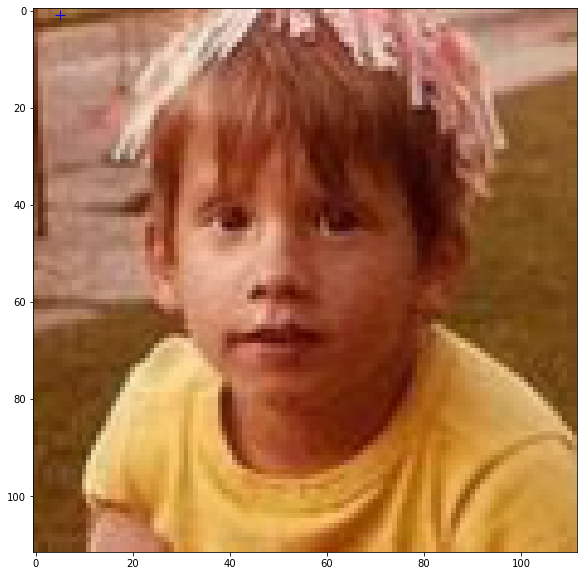

In [42]:

plt.figure(figsize=(10,10))
for img,label in train_ds:
    show(img,label)
    break

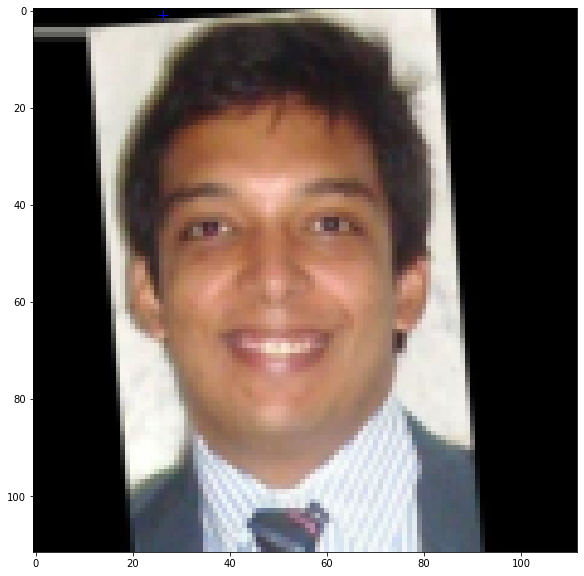

In [43]:
plt.figure(figsize=(10,10))
for img,label in val_ds:
    show(img,label)
    break

In [44]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 256, shuffle=False)

In [45]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([32, 3, 112, 112]) torch.float32
torch.Size([32, 2])


In [46]:
for img, label in val_dl:
    print(label.shape)
    break

torch.Size([256, 2])



# Create Model

In [47]:
import torch.nn as nn
import torch.nn.functional as F


In [48]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [49]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)

In [50]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x


In [51]:
Net.__init__= __init__
Net.forward = forward

params_model={
        "input_shape": (3,112,112),
        "initial_filters": 64, 
        "num_outputs": 1,
            }

model = Net(params_model)
device = torch.device("cuda")
model = model.to(device)

# Create optimizer

In [52]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10,verbose=1)

# Training

In [17]:

from src.models import experiment

performance = experiment.Performance()

path2models= "../models/weights.pt"
params = experiment.Prams(num_epochs=30, path2weights=path2models, device=device,optimizer=opt, lr_scheduler=lr_scheduler, sanity_check=False)

pipeline = experiment.Pipeline(model, train_dl, val_dl, performance, params)
model, performance = pipeline.train_val()



Epoch 0/29, current lr=0.001
Copied best model weights!
train loss: 355.666443
val loss: 222.023209
----------
Epoch 1/29, current lr=0.001
train loss: 224.171616
val loss: 226.707413
----------
Epoch 2/29, current lr=0.001
Copied best model weights!
train loss: 218.197189
val loss: 210.922318
----------
Epoch 3/29, current lr=0.001
train loss: 217.412689
val loss: 216.407242
----------
Epoch 4/29, current lr=0.001
train loss: 210.356964
val loss: 231.861145
----------
Epoch 5/29, current lr=0.001
Copied best model weights!
train loss: 206.775681
val loss: 210.176773
----------
Epoch 6/29, current lr=0.001
Copied best model weights!
train loss: 202.496002
val loss: 201.345398
----------
Epoch 7/29, current lr=0.001
train loss: 196.161591
val loss: 206.422577
----------
Epoch 8/29, current lr=0.001
train loss: 189.900513
val loss: 205.470001
----------
Epoch 9/29, current lr=0.001
Copied best model weights!
train loss: 190.349564
val loss: 184.869812
----------
Epoch 10/29, current lr=0

In [19]:
loss_hist, metric_history = performance.loss_history, performance.metrics_history

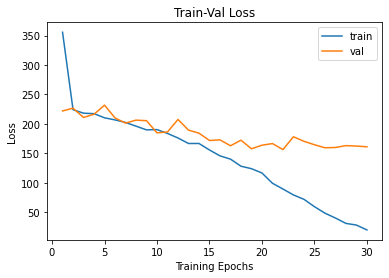

In [28]:
# Train-Validation Progress
num_epochs= 30

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

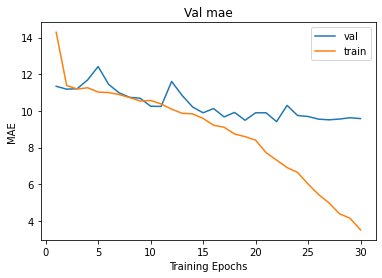

In [33]:
# plot accuracy progress
plt.title("Val mae")
plt.plot(range(1,num_epochs+1),metric_history["val"],label="val")
plt.plot(range(1,num_epochs+1),metric_history["train"],label="train")
plt.ylabel("MAE")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [34]:
min(metric_history["val"])

tensor(9.4199, device='cuda:0')

In [35]:
min(loss_hist["val"])

tensor(156.4000, device='cuda:0')

In [36]:
min(loss_hist["train"])

tensor(19.9846, device='cuda:0', grad_fn=<DivBackward0>)